In [23]:
#Read in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [24]:
#Set pandas preferences
pd.set_option('display.max_columns',100)

#Set matplotlib preferences
plt.style.use('ggplot')

In [25]:
#Import raw data
import os
os.chdir('/Users/ksharma/Documents/Data Science/Projects/TelcoCustomerChurn/Data/CleanedData/')

df= pd.read_csv('cleanedData.csv', index_col= 0)

In [26]:
display(df.shape)
display(df['Churn'].value_counts())
display(df.head())

(7043, 20)

No     5174
Yes    1869
Name: Churn, dtype: int64

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Preprocessing for Machine Learning

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

#Subset col names for oneHotEncoding
oneHotEncodeCols= df.select_dtypes(include='object').columns.tolist()
oneHotEncodeCols= oneHotEncodeCols[:-1] #remove churn

In [28]:
#Encode data and split into X and y
X= pd.get_dummies(df.iloc[:,:-1], columns= oneHotEncodeCols, drop_first=False).values
y= LabelEncoder().fit_transform(df['Churn'].values)

#Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=24)

display(X_train.shape, y_train.shape)
display(X_test.shape, y_test.shape)

(5634, 46)

(5634,)

(1409, 46)

(1409,)

In [29]:
#Standardize training data
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_train[:,0:3]= scaler.fit_transform(X_train[:,0:3])
X_test[:,0:3]= scaler.transform(X_test[:,0:3])

**Base Model for Churn Classification - Logistic Regression**

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, classification_report

scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold= KFold(n_splits=5, random_state=None)

def evaluate_classifier(modelName, estimator, kfold= kfold, scoring= scoring,
                       trainingData= X_train, target= y_train):
    results= cross_validate(estimator= estimator, X= trainingData, y= target, 
                        cv= kfold, n_jobs=-1, scoring=scoring)

    print('%s Metrics:\n==============================' %modelName)
    print('Avg F1 Score: %s SD: %s' % (np.round(np.mean(results['test_f1_score']),4), np.round(np.std(results['test_f1_score']),4)))
    print('Avg Precision Score: %s SD: %s' % (np.round(np.mean(results['test_precision']),4), np.round(np.std(results['test_precision']),4)))
    print('Avg Recall Score: %s SD: %s' % (np.round(np.mean(results['test_recall']),4), np.round(np.std(results['test_recall']),4)))

In [31]:
logiReg= LogisticRegression(n_jobs= -1,penalty= 'l2', C= 1.0, random_state= 24 )

evaluate_classifier(modelName= 'Logistic Regression', estimator= logiReg)

Logistic Regression Metrics:
Avg F1 Score: 0.5962 SD: 0.0078
Avg Precision Score: 0.6534 SD: 0.0192
Avg Recall Score: 0.5488 SD: 0.0138


Base Model for Churn Classification - Linear SVC

In [32]:
from sklearn.svm import LinearSVC

linSVC= LinearSVC(penalty= 'l2', C= 1.0, random_state= 24)

evaluate_classifier(modelName= 'Linear SVC', estimator= linSVC)

Linear SVC Metrics:
Avg F1 Score: 0.5885 SD: 0.0077
Avg Precision Score: 0.6552 SD: 0.0196
Avg Recall Score: 0.5352 SD: 0.0204


K-Nearest-Neighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn= KNeighborsClassifier(n_neighbors= 5, n_jobs= -1)

evaluate_classifier(modelName= 'K-Nearest Neighbors',estimator= knn)

K-Nearest Neighbors Metrics:
Avg F1 Score: 0.5513 SD: 0.0048
Avg Precision Score: 0.5714 SD: 0.023
Avg Recall Score: 0.5337 SD: 0.0144


Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

rForest= RandomForestClassifier(n_jobs= -1, n_estimators= 100, random_state=24)

evaluate_classifier(modelName= 'Random Forest', estimator= rForest)

Random Forest Metrics:
Avg F1 Score: 0.5438 SD: 0.0215
Avg Precision Score: 0.6318 SD: 0.0229
Avg Recall Score: 0.4779 SD: 0.0249


**Selecting Logistic Regression for Optimization**

In [35]:
from sklearn.model_selection import GridSearchCV

params= {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
         'C': [1,.5,.1,.01, .001]
         }
#Set parameters for GridSearch

clf= GridSearchCV(estimator= logiReg, param_grid= params, cv= kfold, scoring= 'f1')
clf.fit(X_train, y_train)

/Users/ksharma/miniforge3/envs/ShallowClassification/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ksharma/miniforge3/envs/ShallowClassification/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ksharma/miniforge3/envs/ShallowClassification/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ksharma/miniforge3/envs/ShallowClassification/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(n_jobs=-1, random_state=24),
             param_grid={'C': [1, 0.5, 0.1, 0.01, 0.001],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='f1')

In [36]:
print('Best params:',clf.best_params_)

Best params: {'C': 1, 'penalty': 'none'}


In [37]:
#Initialize Logistic Regression model with tunes parameters
tunedLogiReg= LogisticRegression(penalty= 'none', C= 1, random_state= 24, n_jobs= -1)
tunedLogiReg.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, penalty='none', random_state=24)

In [38]:
testPreds= tunedLogiReg.predict(X_test)

In [40]:
print('Accuracy:', round(accuracy_score(y_test, testPreds),3))
print('F1 Score:', round(f1_score(y_test, testPreds),3))
print('Precision Score', round(precision_score(y_test, testPreds),3))
print('Recall score',round(recall_score(y_test, testPreds),3))

Accuracy: 0.819
F1 Score: 0.612
Precision Score 0.659
Recall score 0.571


Evaluate Precision/Recall Curve to determine optimal threshold for F-Score

In [41]:
predicitonProbabilities= tunedLogiReg.predict_proba(X_test)[:,1]
predicitonProbabilities

array([0.73346833, 0.09270991, 0.70676946, ..., 0.00675082, 0.05687992,
       0.00484041])

In [42]:
#Generate preciscion recall curve for logiReg
p, r, thresh= precision_recall_curve(y_test, predicitonProbabilities)

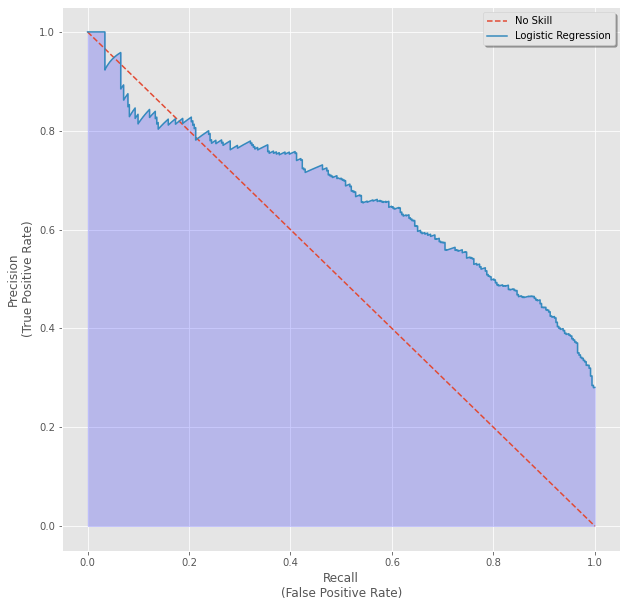

In [43]:
f, ax= plt.subplots(figsize= (10,10))

ax.plot([0,1], [1,0], linestyle= 'dashed', label= 'No Skill')
ax.plot(r, p, label= 'Logistic Regression')

plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
ax.set_xlabel('Recall\n(False Positive Rate)')
ax.set_ylabel('Precision\n(True Positive Rate)')
ax.legend(shadow= True, loc= 'upper right');

In [44]:
report= classification_report(y_test, testPreds)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1057
           1       0.66      0.57      0.61       352

    accuracy                           0.82      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

